In [42]:
import sklearn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, make_scorer
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import accuracy_score, recall_score, f1_score, roc_auc_score
from IPython.display import display, Markdown




from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay

# Exploratory Data Analyisis

En primer lloc, carreguem el nostre dataset i mostrem algunes de les files.

In [43]:
df = pd.read_csv("cardio_train.csv", sep = ';')
display(df)

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
69995,99993,19240,2,168,76.0,120,80,1,1,1,0,1,0
69996,99995,22601,1,158,126.0,140,90,2,2,0,0,1,1
69997,99996,19066,2,183,105.0,180,90,3,1,0,1,0,1
69998,99998,22431,1,163,72.0,135,80,1,2,0,0,0,1


Ens interessa saber si hi ha alguna variable amb valors nuls, i és per això que mirem la informació del dataset.

In [44]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70000 entries, 0 to 69999
Data columns (total 13 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id           70000 non-null  int64  
 1   age          70000 non-null  int64  
 2   gender       70000 non-null  int64  
 3   height       70000 non-null  int64  
 4   weight       70000 non-null  float64
 5   ap_hi        70000 non-null  int64  
 6   ap_lo        70000 non-null  int64  
 7   cholesterol  70000 non-null  int64  
 8   gluc         70000 non-null  int64  
 9   smoke        70000 non-null  int64  
 10  alco         70000 non-null  int64  
 11  active       70000 non-null  int64  
 12  cardio       70000 non-null  int64  
dtypes: float64(1), int64(12)
memory usage: 6.9 MB


Observem que tenim un total de 70000 mostres, de les quals no hi ha cap que té atributs amb valors nuls. Seguidament, volem saber si la variable target (cardio) està balancejada.

In [45]:
df['cardio'].value_counts().reset_index()

,cardio,count
0,0,35021
1,1,34979


<Axes: xlabel='cardio', ylabel='count'>

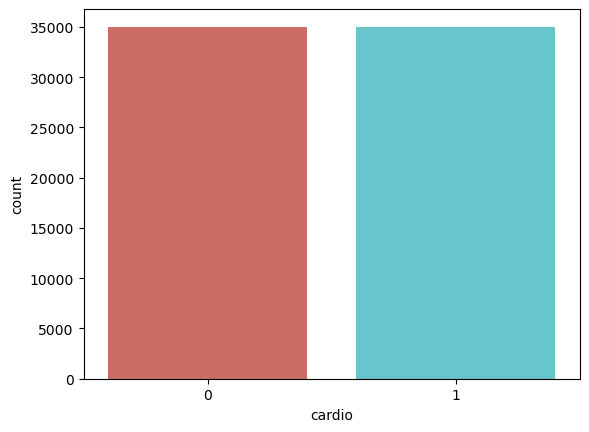

In [46]:
sns.countplot(x='cardio',data=df,palette='hls')

Ara volem tenir una primera visió de com estan correlacionades les variables i per això fem la matriu de correlació.

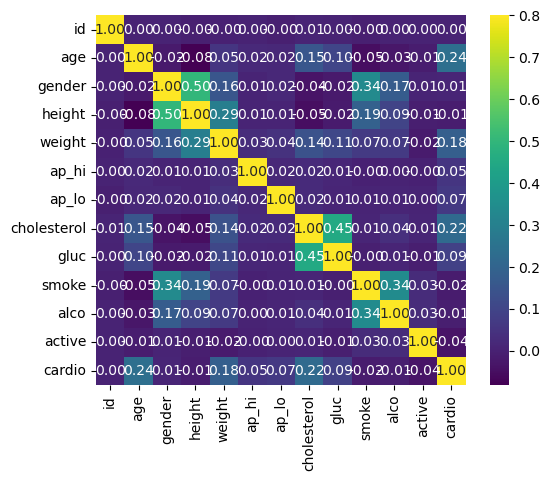

In [47]:
# Draw a heatmap
indexes = df.columns# Use all features for the heatmap
selected_features = df[indexes]
df2 = pd.DataFrame(selected_features, columns = df.columns)
df2['cardio'] = df['cardio']
corrmat = df2.corr()
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, annot=True, fmt='.2f', cmap='viridis')
plt.savefig("corrplot.png", dpi = 300, bbox_inches = 'tight')

In [48]:
# Filtrar alçades fora de rang
df = df[(df['height'] >= 120) & (df['height'] <= 220)]

# Filtrar pesos fora de rang
df = df[(df['weight'] >= 30) & (df['weight'] <= 200)]


In [49]:
# Calculem BMI i eliminem les columnes de height i weight
if {'height', 'weight'}.issubset(df.columns):
    df['height_m'] = df['height'] / 100.0
    df['bmi'] = df['weight'] / (df['height_m']**2)
    df = df.drop(columns={'height','height_m','weight'})

In [50]:
# Convertim l'edat a anys
df['age_in_years'] = (df['age']/365).astype(int)
df = df.drop(columns='age')

In [51]:
# Eliminem quan la low ap sigui més gran que la high ap
df = df[df['ap_lo'] <= df['ap_hi']]

# Filtrem que les ap estiguin dins dels valors considerats normals
df = df[(df['ap_hi'] >= 60) & (df['ap_hi'] <= 250)]
df = df[(df['ap_lo'] >= 40) & (df['ap_lo'] <= 200)]

In [52]:
#No farem servir id, podem borrar la columna
df = df.drop(columns='id')

In [53]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 68618 entries, 0 to 69999
Data columns (total 11 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   gender        68618 non-null  int64  
 1   ap_hi         68618 non-null  int64  
 2   ap_lo         68618 non-null  int64  
 3   cholesterol   68618 non-null  int64  
 4   gluc          68618 non-null  int64  
 5   smoke         68618 non-null  int64  
 6   alco          68618 non-null  int64  
 7   active        68618 non-null  int64  
 8   cardio        68618 non-null  int64  
 9   bmi           68618 non-null  float64
 10  age_in_years  68618 non-null  int32  
dtypes: float64(1), int32(1), int64(9)
memory usage: 6.0 MB


Representem amb countplots i boxplots les distribucions dels atributs segons la variable target.

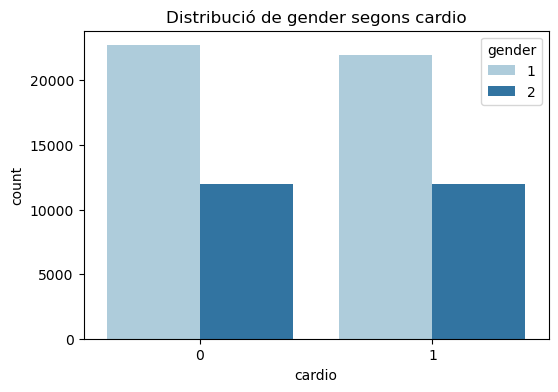

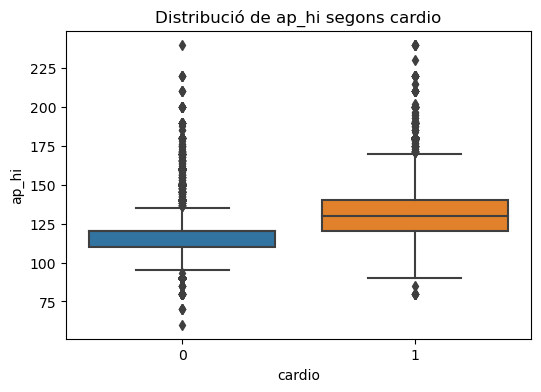

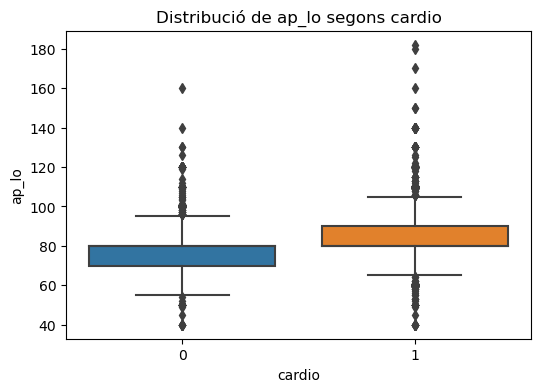

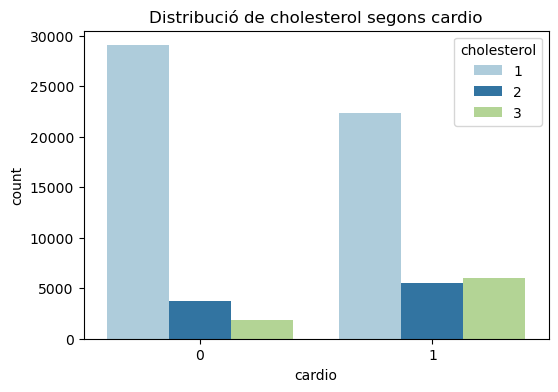

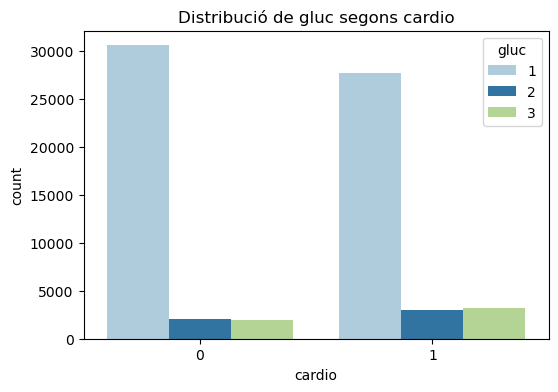

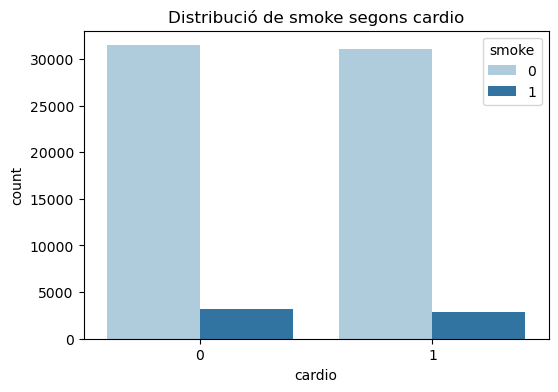

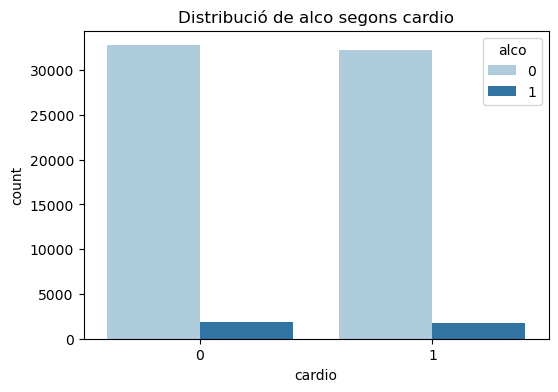

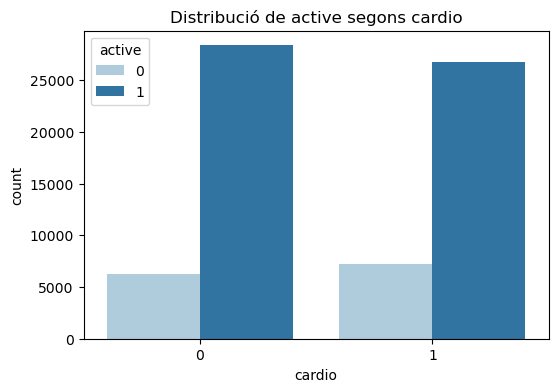

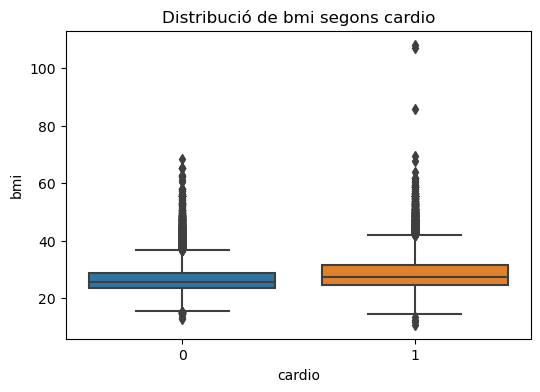

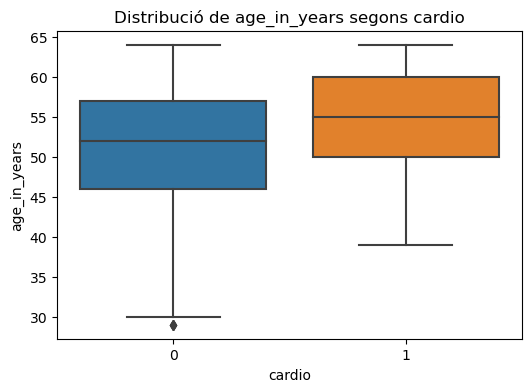

In [54]:
for col in df.columns:
    if col == "cardio":
        continue

    plt.figure(figsize=(6,4))

    #Separem amb categòriques i contínues 
    if df[col].nunique() <= 10: #considerem categòriques les que tenen menys de 10 valors diferents
        sns.countplot(x="cardio", hue=col, data=df, palette="Paired")
        plt.title(f"Distribució de {col} segons cardio")
        plt.legend(title=col)
    else:  
        sns.boxplot(x="cardio", y=col, data=df)
        plt.title(f"Distribució de {col} segons cardio")

    plt.show()


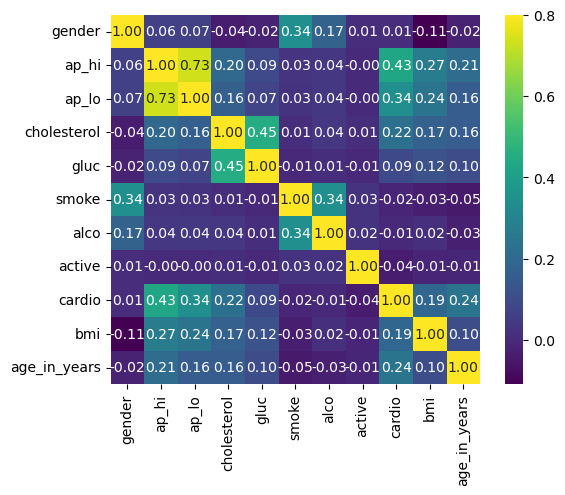

In [55]:
# Draw a heatmap
indexes = df.columns# Use all features for the heatmap
selected_features = df[indexes]
df2 = pd.DataFrame(selected_features, columns = df.columns)
df2['cardio'] = df['cardio']
corrmat = df2.corr()
# Draw the heatmap using seaborn
sns.heatmap(corrmat, vmax = .8, square = True, annot=True, fmt='.2f', cmap='viridis')
plt.savefig("corrplot.png", dpi = 300, bbox_inches = 'tight')

In [56]:
#Normalitzem les variables que no són categòriques
df["age_in_years_scaled"] = (df["age_in_years"] - df["age_in_years"].mean()) / df["age_in_years"].std()
df["ap_hi_scaled"] = (df["ap_hi"] - df["ap_hi"].mean()) / df["ap_hi"].std()
df["ap_lo_scaled"] = (df["ap_lo"] - df["ap_lo"].mean()) / df["ap_lo"].std()
df["bmi_scaled"] = (df["bmi"] - df["bmi"].mean()) / df["bmi"].std()

# Model Selection

In [57]:
explanatory_variables = ["gender", "ap_hi_scaled", "ap_lo_scaled", "cholesterol", "gluc", "smoke", "alco", "active", "bmi_scaled", "age_in_years_scaled"]
X_scaled = df[explanatory_variables]

In [58]:
X = X_scaled
y = df["cardio"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [59]:
results = []

Primera prova de models amb hiperparàmetres per defecte:

In [60]:
logreg = LogisticRegression()
logreg.fit(X_train, y_train)

# LOGISTIC REGRESSION
y_pred = logreg.predict(X_test)
y_prob = logreg.predict_proba(X_test)[:,1]
results.append({
    "Model": "Regressio Logistica",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
})


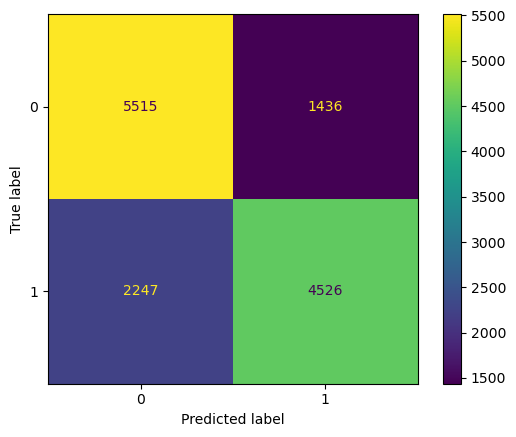

In [61]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [62]:
knn = KNeighborsClassifier()
knn.fit(X_train, y_train)

# KNN
y_pred = knn.predict(X_test)
y_prob = knn.predict_proba(X_test)[:,1]
results.append({
    "Model": "kNN",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
})


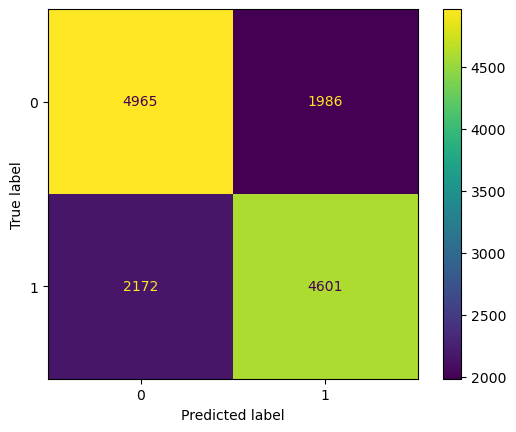

In [63]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [66]:
rf = RandomForestClassifier()
rf.fit(X_train, y_train)

# RANDOM FOREST
y_pred = rf.predict(X_test)
y_prob = rf.predict_proba(X_test)[:,1]
results.append({
    "Model": "Random Forest",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
})



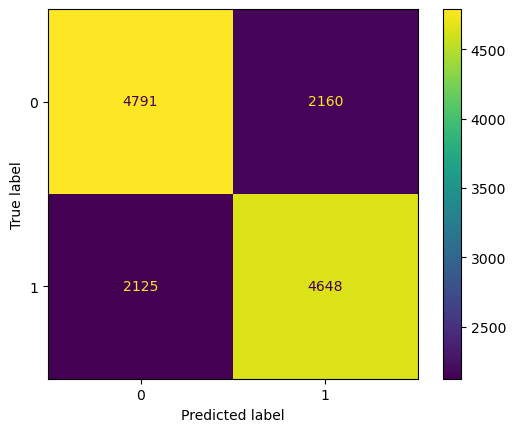

In [67]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [68]:
gb = GradientBoostingClassifier()
gb.fit(X_train, y_train)

# GRADIENT BOOSTING
y_pred = gb.predict(X_test)
y_prob = gb.predict_proba(X_test)[:,1]
results.append({
    "Model": "Gradient Boosting",
    "Accuracy": accuracy_score(y_test, y_pred),
    "Recall": recall_score(y_test, y_pred),
    "F1": f1_score(y_test, y_pred),
    "AUC-ROC": roc_auc_score(y_test, y_prob)
})

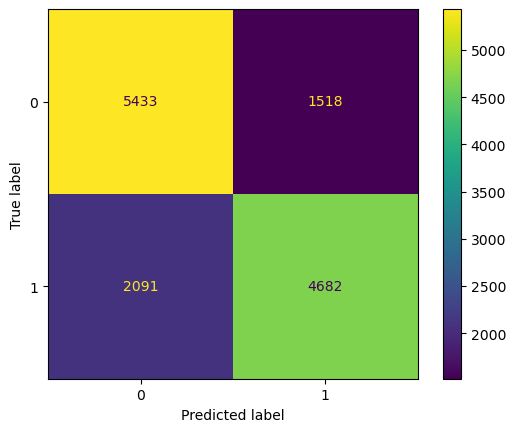

In [69]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

In [70]:
results_df = pd.DataFrame(results)
print(results_df)

                 Model  Accuracy    Recall        F1   AUC-ROC
0  Regressio Logistica  0.731638  0.668242  0.710797  0.791087
1                  kNN  0.697027  0.679315  0.688772  0.746980
2        Random Forest  0.687773  0.686254  0.684486  0.747493
3    Gradient Boosting  0.737030  0.691274  0.721807  0.802051


In [71]:
#Per visualitzar els resultats en una taula
results_df = pd.DataFrame(results)

results_df.style.format({
    "Accuracy": "{:.4f}",
    "Recall": "{:.4f}",
    "F1": "{:.4f}",
    "AUC-ROC": "{:.4f}"
})


,Model,Accuracy,Recall,F1,AUC-ROC
0,Regressio Logistica,0.7316,0.6682,0.7108,0.7911
1,kNN,0.6970,0.6793,0.6888,0.7470
2,Random Forest,0.6878,0.6863,0.6845,0.7475
3,Gradient Boosting,0.7370,0.6913,0.7218,0.8021


Ara provem d'aplicar cross validation

In [ ]:
cv = KFold(n_splits=5, shuffle=True, random_state=42)

# Metrics needed
scoring = {
    "Accuracy": make_scorer(accuracy_score),
    "Recall": make_scorer(recall_score),
    "F1": make_scorer(f1_score),
    "AUC": "roc_auc" 
}

models = {
    "Logistic Regression": LogisticRegression(),
    "kNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}

results_cv = []

for name, model in models.items():
    model_results = {}

    for metric_name, metric in scoring.items():
        scores = cross_val_score(
            estimator=model,
            X=X, y=y,
            scoring=metric,
            cv=cv,
            n_jobs=-1
        )
        model_results[metric_name] = np.mean(scores)

    results_cv.append({
        "Model": name,
        "Accuracy": model_results["Accuracy"],
        "Recall": model_results["Recall"],
        "F1": model_results["F1"],
        "AUC-ROC": model_results["AUC"]
    })

results_df = pd.DataFrame(results_cv)
print(results_df)



                 Model  Accuracy    Recall        F1   AUC-ROC
0  Logistic Regression  0.727462  0.666781  0.707649  0.791079
1                  kNN  0.696902  0.682425  0.690156  0.743943
2        Random Forest  0.689542  0.689953  0.686033  0.745367
3    Gradient Boosting  0.734589  0.691618  0.720518  0.800963


Ara fem la cerca d'hiperparàmetres, començant amb GridSearch

In [73]:
from sklearn.model_selection import GridSearchCV

logreg_params = {
    "C": [0.01, 0.1, 1, 10],
    "penalty": ["l2"],
    "solver": ["lbfgs"],
    "max_iter": [200, 500]
}

grid_logreg = GridSearchCV(
    estimator=LogisticRegression(),
    param_grid=logreg_params,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid_logreg.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=LogisticRegression(), n_jobs=-1,
             param_grid={'C': [0.01, 0.1, 1, 10], 'max_iter': [200, 500],
                         'penalty': ['l2'], 'solver': ['lbfgs']},
             scoring='recall')

In [ ]:
#Codi que s'ha deixat comentat ja que el temps d'execució era molt elevat (146 min)
""""
knn_params = {
    "n_neighbors": [3, 5, 7, 11, 15, 20, 25],
    "weights": ["uniform", "distance"],
    "p": [1, 2]  # manhattan vs euclidean
}

grid_knn = GridSearchCV(
    KNeighborsClassifier(),
    knn_params,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid_knn.fit(X_train, y_train)

"""

GridSearchCV(cv=5, estimator=KNeighborsClassifier(), n_jobs=-1,
             param_grid={'n_neighbors': [3, 5, 7, 11, 15, 20, 25], 'p': [1, 2],
                         'weights': ['uniform', 'distance']},
             scoring='recall')

In [ ]:
#Codi que s'ha deixat comentat ja que el temps d'execució era elevat (14 min)
""""
rf_params = {
    "n_estimators": [200],
    "max_depth": [4, 6, 10, 50],
    "min_samples_split": [2, 5, 10],
    "min_samples_leaf": [1, 2, 4],
    "max_features": ["sqrt", "log2"]
}

grid_rf = GridSearchCV(
    RandomForestClassifier(),
    rf_params,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid_rf.fit(X_train, y_train)
"""

GridSearchCV(cv=5, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': [4, 6, 10, 50],
                         'max_features': ['sqrt', 'log2'],
                         'min_samples_leaf': [1, 2, 4],
                         'min_samples_split': [2, 5, 10],
                         'n_estimators': [200]},
             scoring='recall')

In [ ]:
#Codi que s'ha deixat comentat ja que el temps d'execució era elevat (12 min)
"""
gb_params = {
    "n_estimators": [200, 300, 500],
    "learning_rate": [0.01, 0.05, 0.1],
    "max_depth": [2, 3, 4],
    "subsample": [0.8, 1.0]
}

grid_gb = GridSearchCV(
    GradientBoostingClassifier(),
    gb_params,
    cv=5,
    scoring="recall",
    n_jobs=-1
)

grid_gb.fit(X_train, y_train)
"""

c:\Users\Usuari\anaconda3\Lib\site-packages\joblib\externals\loky\process_executor.py:700: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


GridSearchCV(cv=5, estimator=GradientBoostingClassifier(), n_jobs=-1,
             param_grid={'learning_rate': [0.01, 0.05, 0.1],
                         'max_depth': [2, 3, 4],
                         'n_estimators': [200, 300, 500],
                         'subsample': [0.8, 1.0]},
             scoring='recall')

In [77]:
best_models = {
    "Logistic Regression": grid_logreg,
    "kNN": grid_knn,
    "Random Forest": grid_rf,
    "Gradient Boosting": grid_gb,
}

results = []

for name, grid in best_models.items():
    best_model = grid.best_estimator_


    y_pred = best_model.predict(X_test)
    y_prob = best_model.predict_proba(X_test)[:, 1]


    results.append({
        "Model": name,
        "Best Params": grid.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob),
    })


In [78]:
#Per visualitzar els resultats en una taula
results_df = pd.DataFrame(results)

results_df.style.format({
    "Accuracy": "{:.4f}",
    "Recall": "{:.4f}",
    "F1": "{:.4f}",
    "AUC-ROC": "{:.4f}"
})


,Model,Best Params,Accuracy,Recall,F1,AUC-ROC
0,Logistic Regression,"{'C': 0.1, 'max_iter': 200, 'penalty': 'l2', 'solver': 'lbfgs'}",0.7315,0.6681,0.7106,0.7911
1,kNN,"{'n_neighbors': 25, 'p': 2, 'weights': 'distance'}",0.7074,0.6936,0.7006,0.7515
2,Random Forest,"{'max_depth': 50, 'max_features': 'log2', 'min_samples_leaf': 1, 'min_samples_split': 5, 'n_estimators': 200}",0.7054,0.7012,0.7014,0.7667
3,Gradient Boosting,"{'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 500, 'subsample': 0.8}",0.7366,0.7003,0.7241,0.8022


In [ ]:
from sklearn.model_selection import RandomizedSearchCV

param_distributions = {
    "Gradient Boosting":{
        "n_estimators": [200, 300, 500],
        "learning_rate": [0.01, 0.05, 0.1],
        "max_depth": [2, 3, 4],
        "subsample": [0.8, 1.0]
    },
    "Logistic Regression":{
        "C": [0.01, 0.1, 1, 10],
        "penalty": ["l2"],
        "solver": ["lbfgs"],
        "max_iter": [200, 500]
    },
    "Random Forest": {
        "n_estimators": [200, 400],
        "max_depth": [4, 6, 10, 50, 100],
        "min_samples_split": [2, 5, 10],
        "min_samples_leaf": [1, 2, 4],
        "max_features": ["sqrt", "log2"]
    },
    "kNN":{
        "n_neighbors": [3, 5, 7, 11, 15, 20, 25],
        "weights": ["uniform", "distance"],
        "p": [1, 2] 
    }
}


models = {
    "Logistic Regression": LogisticRegression(),
    "kNN": KNeighborsClassifier(),
    "Random Forest": RandomForestClassifier(),
    "Gradient Boosting": GradientBoostingClassifier(),
}


best_models = {}
results = []

for name, model in models.items():


    rs = RandomizedSearchCV(
        estimator=model,
        param_distributions=param_distributions[name],
        n_iter=20,                
        scoring="recall",    
        cv=5,
        n_jobs=-1,
        random_state=42,
        verbose=1
    )

    start = time.time()
    rs.fit(X_train, y_train)
    exec_time = time.time() - start

    best_models[name] = rs.best_estimator_

    y_pred = rs.best_estimator_.predict(X_test)
    y_prob = rs.best_estimator_.predict_proba(X_test)[:, 1]

    results.append({
        "Model": name,
        "Best Params": rs.best_params_,
        "Accuracy": accuracy_score(y_test, y_pred),
        "Recall": recall_score(y_test, y_pred),
        "F1": f1_score(y_test, y_pred),
        "AUC-ROC": roc_auc_score(y_test, y_prob),
        "Search Time (s)": exec_time
    })

results_df = pd.DataFrame(results)
results_df


c:\Users\Usuari\anaconda3\Lib\site-packages\sklearn\model_selection\_search.py:318: UserWarning: The total space of parameters 8 is smaller than n_iter=20. Running 8 iterations. For exhaustive searches, use GridSearchCV.
  warnings.warn(


Fitting 5 folds for each of 8 candidates, totalling 40 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits
Fitting 5 folds for each of 20 candidates, totalling 100 fits


,Model,Best Params,Accuracy,Recall,F1,AUC-ROC,Search Time (s)
0,Logistic Regression,"{'solver': 'lbfgs', 'penalty': 'l2', 'max_iter...",0.731492,0.668094,0.710640,0.791079,1.328226
1,kNN,"{'weights': 'distance', 'p': 2, 'n_neighbors':...",0.704532,0.693341,0.698446,0.748521,55.115483
2,Random Forest,"{'n_estimators': 400, 'min_samples_split': 10,...",0.717138,0.702790,0.710342,0.780545,253.580722
3,Gradient Boosting,"{'subsample': 1.0, 'n_estimators': 200, 'max_d...",0.734917,0.693932,0.720969,0.801371,246.031074


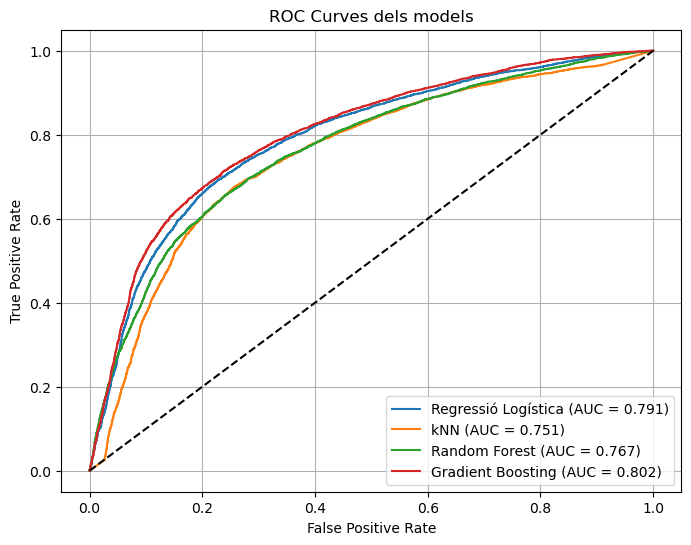

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

models = {
    "Regressió Logística": grid_logreg,
    "kNN": grid_knn,
    "Random Forest": grid_rf,
    "Gradient Boosting": grid_gb
}

plt.figure(figsize=(8,6))

for name, model in models.items():
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.plot(fpr, tpr, label=f"{name} (AUC = {roc_auc:.3f})")

plt.plot([0, 1], [0, 1], 'k--')

plt.title("ROC Curves dels models")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.legend()
plt.grid(True)
plt.show()
